#1 Importar datos

In [ ]:
#imports

#procesamiento
import numpy as np
import pandas as pd

#graficos
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter

#regresion
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [ ]:
#urls de los google sheets
raw_pet = pd.read_csv("https://tinyurl.com/petroleoproc")
raw_gas = pd.read_csv("https://tinyurl.com/gasproc")

In [ ]:
#filtro concepto
conceptos_pet = ["Producción Primaria (m3)"]

conceptos_gas = ["Gas de Baja Presión",
                 "Gas de Baja Presión (Mm3)"]
pet_fl = raw_pet[raw_pet['concepto'].isin(conceptos_pet)]
gas_fl = raw_gas[raw_gas['concepto'].isin(conceptos_gas)]

In [ ]:
#agrupacion
pet_fl = pet_fl.groupby(["anio","mes"])["Cantidad"].sum().reset_index()
gas_fl = gas_fl.groupby(["anio","mes"])["Cantidad"].sum().reset_index()

##1.2 Extension del dataset

In [ ]:
def extender(datos):
    for i in range(7,13):
        datos = pd.concat([datos,
                      pd.DataFrame({"anio" : [2023],
                                    "mes" : [i]})],
                      ignore_index=True,
                      axis = 0)
    for i in range(1,13):
        datos = pd.concat([datos,
                          pd.DataFrame({"anio" : [2024],
                                        "mes" : [i]})],
                          ignore_index=True,
                          axis = 0)
    return datos

In [ ]:
pet = extender(pet_fl)
gas = extender(gas_fl)

##1.3 Media movil




In [ ]:
#media movil
ventana = 12
pet["mmP"] = pet["Cantidad"].rolling(window=ventana).mean()
gas["mmG"] = gas["Cantidad"].rolling(window=ventana).mean()
pet["fecha"] = pd.to_datetime(pet[['anio', 'mes']].assign(day=1).astype(str).agg('-'.join, axis=1))
gas["fecha"] = pd.to_datetime(gas[['anio', 'mes']].assign(day=1).astype(str).agg('-'.join, axis=1))


##1.4 correlacion pearson

In [ ]:
#coeficiente de correlacion de pearson
from scipy.stats import pearsonr
prc, pvalue = pearsonr(pet.loc[0:365,"Cantidad"],gas.loc[0:365,"Cantidad"])
prc = round(prc,2)
print(f"{'Coeficiente de correlacion de pearson:':30}",prc)

Coeficiente de correlacion de pearson: -0.66


#2 Graficos

##2.1 formato eje y

In [ ]:
formatter = ScalarFormatter()
formatter.set_scientific(False)
formatter.set_useOffset(False)

##2.2 serie de tiempo media movil

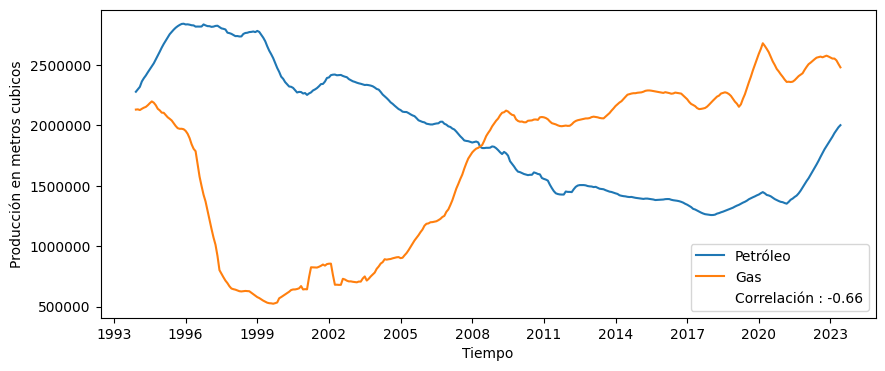

In [ ]:
#graficar
plt.figure(figsize=(10,4))
plt.plot(pet["mmP"], label = "Petróleo")
plt.plot(gas["mmG"], label = "Gas")
plt.plot([], [], label= f'Correlación : {prc}',color = "white")
#plt.title("Serie de tiempo: Producción de gas y petróleo")
plt.xlabel("Tiempo")
plt.ylabel("Producción en metros cubicos")
plt.xticks(ticks = range(len(pet))[::36],
           labels = pet["anio"].unique()[::3],
           rotation = 0)
plt.gca().yaxis.set_major_formatter(formatter)
plt.legend()
plt.show()

#3 Analisis

##3.1Tendencia

In [ ]:
#regresion no linear 2
flag = True
def nonlinear_function(x, a, b, c,d):
    return a*x + b*x**2 +c*x**3 +d

x_data = np.array(list(range(12,365)))
y_data = pet.loc[13:365,"mmP"].values

params, covariance = curve_fit(nonlinear_function, x_data, y_data)
aP, bP, cP,dP= params

print(f"{'coefficient a':15}",aP)
print(f"{'coefficient b':15}",bP)
print(f"{'coefficient c':15}",cP)
print(f"{'d(intercept)':15}",dP)


coefficient a   5568.010671277525
coefficient b   -86.4401649215311
coefficient c   0.17902201118853156
d(intercept)    2600843.832253562


In [ ]:
#regresion no linear 2
flag = True
def nonlinear_function(x, a, b, c,d,e):
    return a*x + b*x**2 +c*x**3 +d*x**4 +e

x_data = np.array(list(range(12,365)))
y_data = gas.loc[13:365,"mmG"].values

params, covariance = curve_fit(nonlinear_function, x_data, y_data)
aG, bG, cG, dG, eG= params

print(f"{'coefficient a':15}",aG)
print(f"{'coefficient b':15}",bG)
print(f"{'coefficient c':15}",cG)
print(f"{'coefficient d':15}",dG)
print(f"{'e(intercept)':15}",eG)


coefficient a   -85089.18133176146
coefficient b   771.5231878826052
coefficient c   -2.517764732937907
coefficient d   0.0028022249203365
e(intercept)    3663649.4330677264


In [ ]:
pet["tendencia"] = aP * pet.index + bP * (pet.index**2) + cP * (pet.index**3) + dP
gas["tendencia"] = aG * gas.index + bG * (gas.index**2) + cG * (gas.index**3) + dG * (gas.index**4) + eG


###3.1.1 Grafico

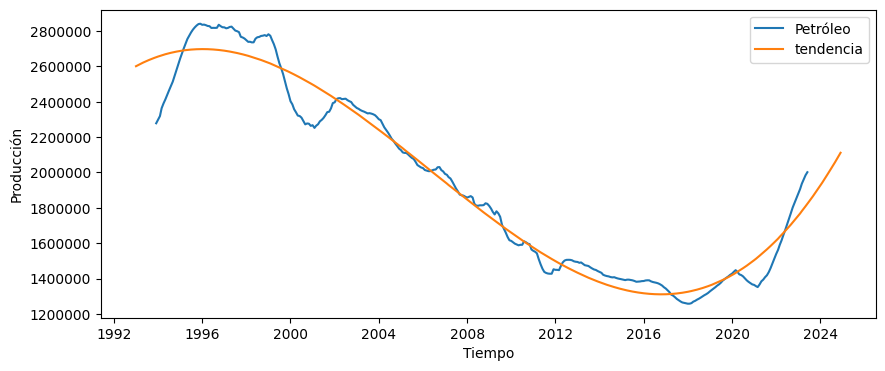

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(pet["fecha"],pet["mmP"],label="Petróleo")
plt.plot(pet["fecha"],pet["tendencia"],label ="tendencia")
plt.xlabel("Tiempo")
plt.ylabel("Producción")
plt.legend()
plt.gca().yaxis.set_major_formatter(formatter)

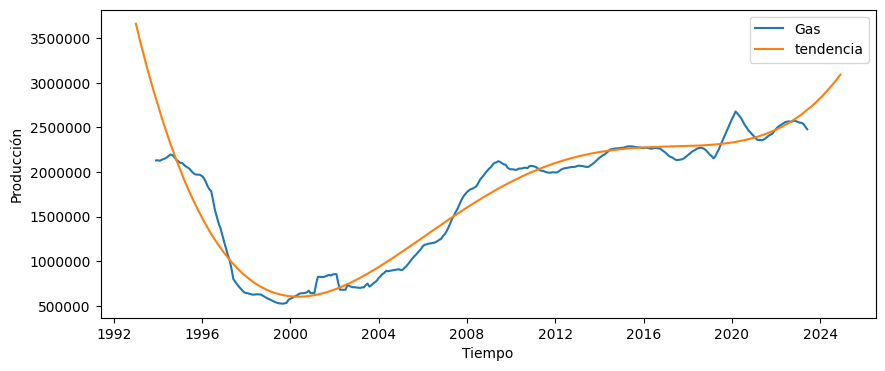

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(gas["fecha"],gas["mmG"],label = "Gas")
plt.plot(gas["fecha"],gas["tendencia"],label = "tendencia")
plt.legend()
plt.xlabel("Tiempo")
plt.ylabel("Producción")
plt.gca().yaxis.set_major_formatter(formatter)

##3.2 Estacionalidad

In [ ]:
#modelo aritmetico
def estacionalidad(datos):
    dic = {}
    meses = ['Enero', 'Febrero', 'Marzo', 'Abril',
             'Mayo', 'Junio', 'Julio', 'Agosto',
             'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']
    for i in range(12):#te da una lista de las cantidades por mes
        dic[meses[i]] = datos.loc[datos["mes"] == i+1,"Cantidad"].reset_index(drop = True)

    dic = pd.DataFrame(dic)
    dic = dic.T

    dic["suma"] = dic.sum(axis=1)
    dic["media"] = dic.mean(axis=1)
    pi = dic["media"].sum()
    dic["fe"] = dic["media"] / (pi/12)
    print( dic["fe"].sum())
    return dic["fe"]

In [ ]:
fe_pet = estacionalidad(pet[0:348])
fe_gas = estacionalidad(gas[0:348])

11.999999999999998
11.999999999999998


In [ ]:
fe_pet

Enero         1.024762
Febrero       0.924308
Marzo         1.020753
Abril         0.981754
Mayo          1.013609
Junio         0.974513
Julio         1.018826
Agosto        1.020010
Septiembre    0.996390
Octubre       1.029677
Noviembre     0.983418
Diciembre     1.011982
Name: fe, dtype: float64

In [ ]:
fe_gas

Enero         0.970378
Febrero       0.889601
Marzo         1.010153
Abril         0.993994
Mayo          1.040657
Junio         1.034887
Julio         1.057579
Agosto        1.069836
Septiembre    1.002230
Octubre       1.005203
Noviembre     0.943425
Diciembre     0.982057
Name: fe, dtype: float64

In [ ]:
pet["fe"] = np.tile(fe_pet,32)
gas["fe"] = np.tile(fe_gas,32)

##3.3 comportamiento aleatorio

In [ ]:
pet["error"] = pet["tendencia"] * pet["fe"]
pet["error"] = pet["Cantidad"] - pet["error"]
pet["error"] = pet["error"]**2
errorP = pet["error"].sum()
errorP = errorP / 366
errorP

18543404345.80923

In [ ]:
gas["error"] = gas["tendencia"] * gas["fe"]
gas["error"] = gas["Cantidad"] - gas["error"]
gas["error"] = gas["error"]**2
errorG = gas["error"].sum()
errorG = errorG / 366
errorG

84260932247.19946

#4 Prediccion

In [ ]:
pet["prediccion"] = pet["tendencia"] * pet["fe"]
gas["prediccion"] = gas["tendencia"] * gas["fe"]


##4.1 Prediccion por serie de tiempo

In [ ]:
pet_pred = pet
gas_pred = gas
pet_pred.loc[pet_pred.index[-18:], 'Cantidad'] = pet_pred['tendencia'].iloc[-18:] * pet_pred['fe'].iloc[-18:]
gas_pred.loc[gas_pred.index[-18:], 'Cantidad'] = gas_pred['tendencia'].iloc[-18:] * gas_pred['fe'].iloc[-18:]

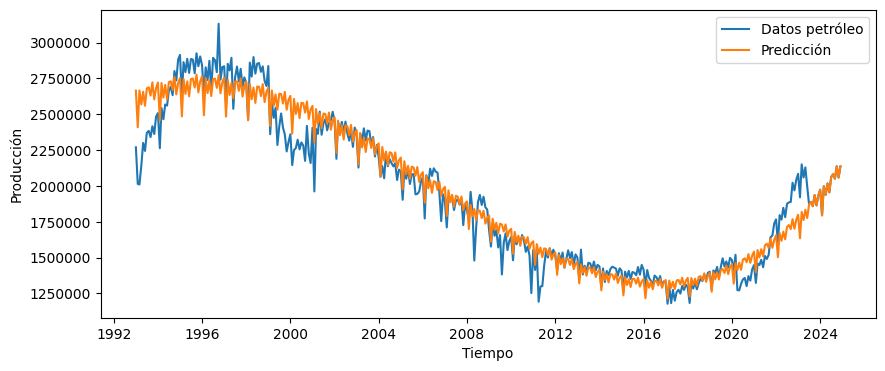

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(pet["fecha"], pet["Cantidad"],label="Datos petróleo")
plt.plot(pet["fecha"], pet["prediccion"],label="Predicción")
plt.xlabel("Tiempo")
plt.ylabel("Producción")
plt.legend()
plt.gca().yaxis.set_major_formatter(formatter)
plt.show()

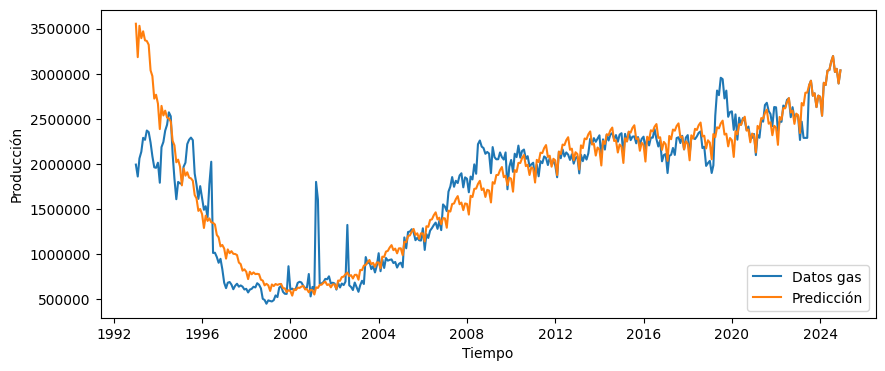

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(gas["fecha"], gas["Cantidad"],label="Datos gas")
plt.plot(gas["fecha"], gas["prediccion"],label="Predicción")
plt.xlabel("Tiempo")
plt.ylabel("Producción")
plt.legend()
plt.gca().yaxis.set_major_formatter(formatter)
plt.show()

In [ ]:
ventana = 12
pet_pred["mmP"] = pet_pred["Cantidad"].rolling(window=ventana).mean()
gas_pred["mmG"] = gas_pred["Cantidad"].rolling(window=ventana).mean()

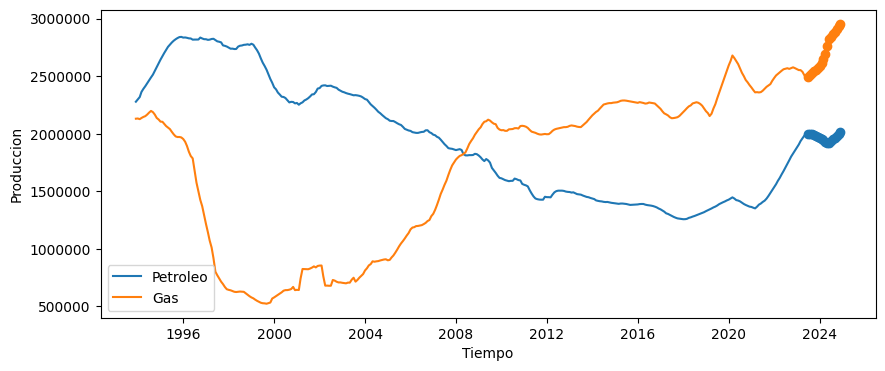

In [ ]:
plt.figure(figsize = (10,4))
plt.plot(pet_pred["fecha"],pet_pred["mmP"],label= "Petroleo")
plt.scatter(pet_pred.loc[366:,"fecha"],pet_pred.loc[366:,"mmP"])
plt.plot(gas_pred["fecha"],gas_pred["mmG"],label = "Gas")
plt.scatter(gas_pred.loc[366:,"fecha"],gas_pred.loc[366:,"mmG"])
plt.xlabel("Tiempo")
plt.ylabel("Produccion")
plt.legend()
plt.gca().yaxis.set_major_formatter(formatter)

##4.2 Prediccion por regresion

In [ ]:
#train test split
x_train = pet_pred.loc[0:365,"Cantidad"].values.reshape(-1,1)
x_test = pet_pred.loc[366:383,"Cantidad"].values.reshape(-1,1)
y_train = gas_pred.loc[0:365,"Cantidad"].values

In [ ]:
modeloRL = LinearRegression()
modeloRL.fit(x_train,y_train)
inter = modeloRL.intercept_
coef = modeloRL.coef_[0]
print (f"y = {round(coef,2)} * X + {round(inter,2)}")

y = -0.88 * X + 3420604.48


In [ ]:
train_preds = modeloRL.predict(x_train)
test_preds = modeloRL.predict(x_test)
error = r2_score(y_train,train_preds)
print(f"error del modelo: {error}")

error del modelo: 0.4341529959051196


###4.2.1 Grafico

Text(0, 0.5, 'Gas')

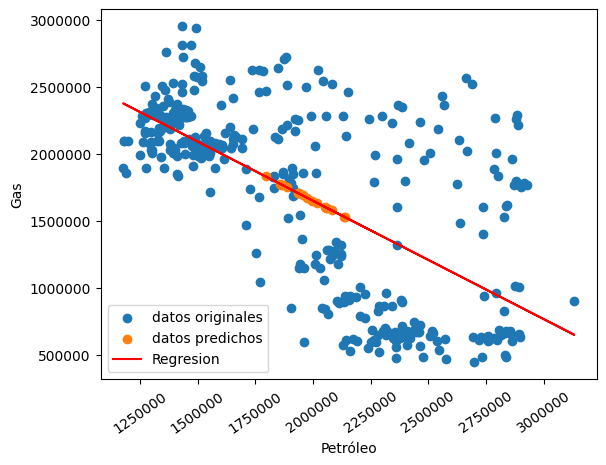

In [ ]:
plt.scatter(x_train,y_train,label="datos originales")
plt.scatter(x_test,test_preds,label="datos predichos")

y = list((coef * x + inter) for x in x_train)
plt.plot(x_train,train_preds,label = "Regresion",color="red")
plt.legend()
plt.xticks(rotation=35)
plt.gca().yaxis.set_major_formatter(formatter)
plt.gca().xaxis.set_major_formatter(formatter)
plt.xlabel("Petróleo")
plt.ylabel("Gas")

#6 Serie proyectada

In [ ]:
ventana = 12
pet["mmP"] = pet["Cantidad"].rolling(window=ventana).mean()
gas["mmG"] = gas["Cantidad"].rolling(window=ventana).mean()

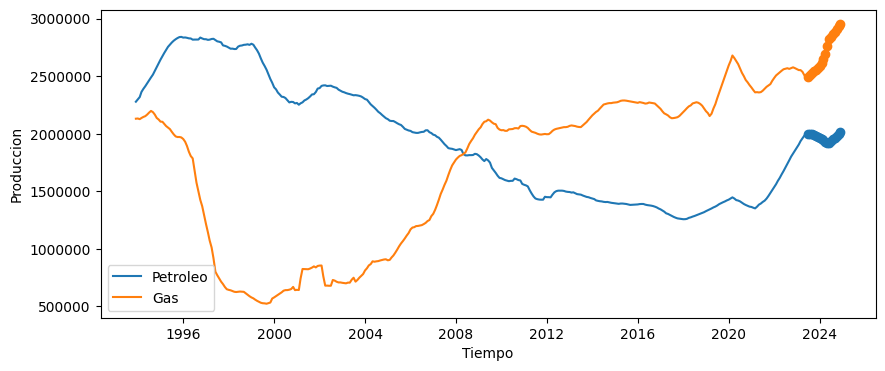

In [ ]:
plt.figure(figsize = (10,4))
plt.plot(pet["fecha"],pet["mmP"],label= "Petroleo")
plt.scatter(pet.loc[366:,"fecha"],pet.loc[366:,"mmP"])
plt.plot(pet["fecha"],gas["mmG"],label = "Gas")
plt.scatter(gas.loc[366:,"fecha"],gas.loc[366:,"mmG"])
plt.xlabel("Tiempo")
plt.ylabel("Produccion")
plt.legend()
plt.gca().yaxis.set_major_formatter(formatter)

In [ ]:
print("proyeccion gas dic 2024:",gas.iloc[383,2])

proyeccion gas dic 2024: 3037517.4615944573


In [ ]:
print("proyeccion petroleo dic 2024:",pet.iloc[383,2])

proyeccion petroleo dic 2024: 2136662.7131115934


# 5 intervalo de confianza

## Gas

In [ ]:
ligas = gas.iloc[383,2] - 1.96 * (errorG**(1/2))
lsgas = gas.iloc[383,2] + 1.96 * (errorG**(1/2))
print(ligas)
print(lsgas)

2468573.8815086624
3606461.041680252


In [ ]:
gas_pred["li"] = gas["mmG"] - (1.96 * (errorG**(1/2)))
gas_pred["ls"] = gas["mmG"] + (1.96 * (errorG**(1/2)))

## Petróleo

In [ ]:
lipet = pet.iloc[383,2] - 1.96 * (errorP**(1/2))
lspet = pet.iloc[383,2] + 1.96 * (errorP**(1/2))
print(lipet)
print(lspet)

1869761.3415623624
2403564.0846608244


In [ ]:
pet["li"] = pet["mmP"] - (1.96 * (errorP**(1/2)))
pet["ls"] = pet["mmP"] + (1.96 * (errorP**(1/2)))

## Gráfico

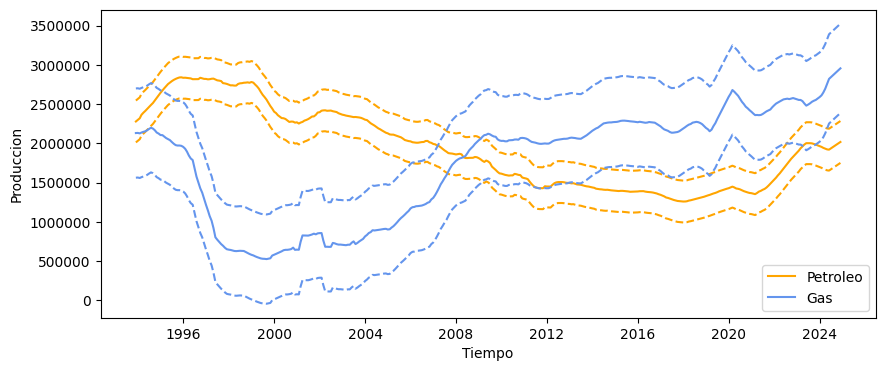

In [ ]:
plt.figure(figsize = (10,4))
plt.plot(pet["fecha"],pet["mmP"],label= "Petroleo",color="orange")
plt.plot(pet["fecha"],pet["ls"],color="orange",linestyle="--")
plt.plot(pet["fecha"],pet["li"],color="orange",linestyle="--")
plt.plot(pet["fecha"],gas["mmG"],label = "Gas",color="cornflowerblue")
plt.plot(gas["fecha"],gas["ls"],color="cornflowerblue",linestyle="--")
plt.plot(gas["fecha"],gas["li"],color="cornflowerblue",linestyle="--")

plt.xlabel("Tiempo")
plt.ylabel("Produccion")
plt.legend()
plt.gca().yaxis.set_major_formatter(formatter)